In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
from torch.nn import functional as F
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import mpl

from main import device

mpl.rcParams["font.sans-serif"] = ["SimHei"]

In [ ]:
data_train = torchvision.datasets.MNIST(root="../data", train=True, download=True, transform=transforms.ToTensor())
data_test = torchvision.datasets.MNIST(root="../data", train=False, download=True, transform=transforms.ToTensor())

In [ ]:
data_iter = data.DataLoader(data_train, batch_size=512*2*4, shuffle=True,num_workers=4,pin_memory=True)

In [ ]:
class Net(nn.Module):
    def __init__(self,num_inputs,num_outputs,num_hidden1,num_hidden2,is_Training = True):
        super().__init__()
        self.input_nums = num_inputs
        self.training = is_Training
        self.relu = nn.ReLU()
        self.hidden1 = nn.Linear(num_inputs, num_hidden1)
        self.hidden2 = nn.Linear(num_hidden1, num_hidden2)
        self.output = nn.Linear(num_hidden2, num_outputs)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.2)
    def forward(self, x):
        o = self.relu(self.hidden1(x.reshape(-1,self.input_nums)))
        if self.training:
            o = self.dropout1(o)
        o = self.relu(self.hidden2(o))
        if self.training:
            o = self.dropout2(o)
        return self.output(o)

In [ ]:
class ConNet(nn.Module):
    def __init__(self,num_inputs,num_outputs,is_Training = True):
        super().__init__()
        self.input_nums = num_inputs
        self.training = is_Training
        self.net = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64,128),
            nn.ReLU(),
            nn.Linear(128,num_outputs),
        )
    def forward(self,x):
        return self.net(x)

In [ ]:
cnet = ConNet(28*28,10)

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            total_loss += loss(outputs, y).item() * x.size(0)
    return total_loss / len(data_loader.dataset)

In [ ]:
def train(train_data:torch.utils.data.dataloader.DataLoader,test_data,model:Net,lr,epochs:int)->tuple[list,list]:
    train_loss = []
    test_loss = []
    test_iter = data.DataLoader(test_data,batch_size=512*2,shuffle=True,num_workers=4,pin_memory=True)
    opt = torch.optim.Adam(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        for x,y in train_data:
            x = x.to(device)
            y = y.to(device)
            opt.zero_grad()
            l = loss(model(x),y)
            l.backward()
            opt.step()
        print(f'完成了第{epoch+1}次训练')
        # 在训练循环中添加
        train_loss.append(evaluate(model, train_data))
        test_loss.append(evaluate(model, test_iter))
        
    return train_loss,test_loss


In [71]:
net = Net(28*28,10,100,100)
cnet = ConNet(28*28,10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [72]:
net.to(device=device)
cnet.to(device=device)
Train_loss,Test_loss = train(data_iter,data_test,cnet,0.01,24)

完成了第1次训练
完成了第2次训练
完成了第3次训练
完成了第4次训练
完成了第5次训练
完成了第6次训练
完成了第7次训练
完成了第8次训练
完成了第9次训练
完成了第10次训练
完成了第11次训练
完成了第12次训练
完成了第13次训练
完成了第14次训练
完成了第15次训练
完成了第16次训练
完成了第17次训练
完成了第18次训练
完成了第19次训练
完成了第20次训练
完成了第21次训练
完成了第22次训练
完成了第23次训练
完成了第24次训练


[0.29246777453422546, 0.08642226542234421, 0.05552297894358635, 0.0447465914607048, 0.0326213737487793, 0.03510855105519295, 0.03133448590040207, 0.039141815891861914, 0.033018099561333655, 0.032012263238430025, 0.035761117893457414, 0.03987081524133682, 0.02809793913960457, 0.02889366953074932, 0.03752668113708496, 0.03083229157626629, 0.03975190590023994, 0.03255682150125504, 0.03321451196074486, 0.03295687834024429, 0.04349221743345261, 0.043857731765508653, 0.05665853538513184, 0.044219629335403444]


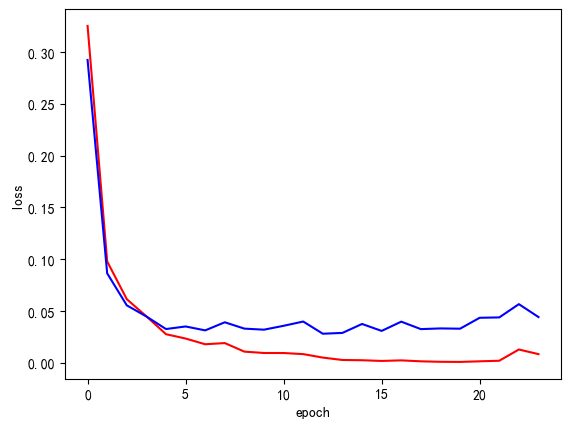

In [73]:
plt.figure("展示图")
print(Test_loss)
plt.plot(Train_loss,label='train',color='r')
plt.plot(Test_loss,label='test',color='b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [87]:
cnet.to(device='cpu')
wrong_list = []
for p in range(10000):
    pre = cnet(data_test[p][0].reshape([1,1,28,28])).argmax().item()
    true = data_test[p][1]
    if pre != true:
        wrong_list.append(p)
print(f"错误个数{len(wrong_list)}")
torch.save(cnet.state_dict(),"cnet.pth")

错误个数113


5
5


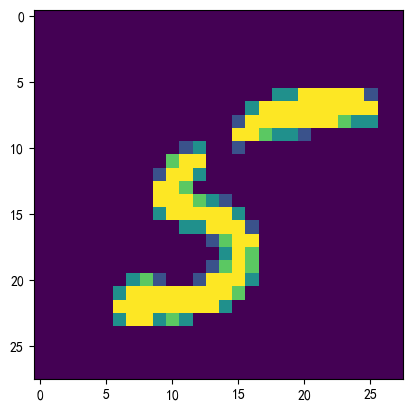

In [79]:
cnet.eval()
p = 47
print(cnet(data_train[p][0].reshape((1,1,28,28))).argmax().item())
print(data_train[p][1])
plt.imshow(data_train[p][0][0])

In [ ]:
import tkinter as tk
from PIL import Image, ImageDraw

In [ ]:
class DigitRecognizer:
    def __init__(self, model):
        # 加载训练好的模型
        self.model = model.to('cpu')
        
        # 创建主窗口
        self.window = tk.Tk()
        self.window.title("手写数字识别")
        
        # 创建画布
        self.canvas_width = 280
        self.canvas_height = 280
        self.canvas = tk.Canvas(self.window, 
                               width=self.canvas_width,
                               height=self.canvas_height,
                               bg="black")
        self.canvas.pack()
        
        # 创建界面控件
        self.btn_recognize = tk.Button(self.window,
                                      text="识别",
                                      command=self.recognize)
        self.btn_recognize.pack(side=tk.LEFT)
        
        self.btn_clear = tk.Button(self.window,
                                  text="清除",
                                  command=self.clear)
        self.btn_clear.pack(side=tk.RIGHT)
        
        self.lbl_result = tk.Label(self.window,
                                 text="预测结果：",
                                 font=("Arial", 20))
        self.lbl_result.pack()
        
        # 初始化绘图变量
        self.image = Image.new("L", (self.canvas_width, self.canvas_height), 0)
        self.draw = ImageDraw.Draw(self.image)
        
        # 绑定鼠标事件
        self.canvas.bind("<B1-Motion>", self.paint)
        
        self.input = None
        
    def paint(self, event):
        # 绘制白色线条（在黑色背景上）
        x, y = event.x, event.y
        r = 10  # 线条半径
        self.canvas.create_oval(x-r, y-r, x+r, y+r, 
                               fill="white", outline="white")
        self.draw.ellipse([x-r, y-r, x+r, y+r], fill=255)
        
    def preprocess_image(self):
        # 缩放并处理图像
        img = self.image.resize((28, 28))  # 缩放到MNIST大小
        img_array = np.array(img) / 255.0  # 归一化
        
        # 调整维度匹配模型输入要求
        return img_array.reshape(1,1,28,28)
    
    def recognize(self):
        # 预处理图像
        processed_img = self.preprocess_image()
        self.input = processed_img
        # 进行预测
        processed_img=torch.from_numpy(processed_img).float()
        predictions = self.model(processed_img)
        predictions = predictions.detach()
        predictions = F.softmax(predictions,dim=1)
        predicted_digit = predictions.argmax()
        confidence = predictions.max()
        
        # 显示结果
        self.lbl_result.config(
            text=f"预测结果：{predicted_digit}（置信度：{confidence:.2f}）"
        )
    
    def clear(self):
        self.canvas.delete("all")
        self.image = Image.new("L", (self.canvas_width, self.canvas_height), 0)
        self.draw = ImageDraw.Draw(self.image)
        self.lbl_result.config(text="预测结果：")
    
    def run(self):
        self.window.mainloop()

In [98]:
recognizer = DigitRecognizer(cnet)
recognizer.run()